In [151]:
import pandas as pd
import json
import os
import gpxo
import gpxpy
import gpxpy.gpx
import fitdecode
import warnings
import tcxparser
from tcxreader.tcxreader import TCXReader, TCXExercise
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

### Feature creation para arquivos Json

In [152]:
def json_processed_data(folder_path):

    '''Função para ler todas as atividades do atleta com arquivos no formato json e a partir disso retornar um conjunto com as features criadas'''

    # Contador de arquivos dentro da pasta
    files_count = len(os.listdir(folder_path))

    # Caminho do arquivo de atividade com {} para inserir o número
    # Nome do arquivo no formato: atividades(x).json onde x >= n.
    filename = "atividades ({}).json"

    full_path = os.path.join(folder_path, filename)  
    n = 1 # Se as atividades começarem por ex com 0, então mudar para n = 0.

    # Leitura de cada uma das atividades no formato json com json.load. 
    activities_data = [json.load(open(full_path.format(activity),"rb")) for activity in range(n, files_count + n)]

    df = pd.DataFrame(activities_data)

    # Lista das metricas que serão identificadas
    metrics = ['distance', 'pace', 'speed']

    # Dicionário com as features que serão criadas com o valor de cada atividade
    df_athlete_dict = {
        'total_distance (km)': [], 
        'pace (min/km)': [],
        'speed (km/h)': []    
    }

    # Iteração no número de atividades
    for activity in range(len(df)):
        # Iteração para encontrar a linha com a métrica desejada e adicionar seu valor no dicionário com a chave certa
        for values in df['summaries'][activity]: # por atividade
            if (values['metric'] == metrics[0]): 
                df_athlete_dict['total_distance (km)'].append(round(values['value'],2))
            elif (values['metric'] == metrics[1]):
                df_athlete_dict['pace (min/km)'].append(round(values['value'],2))
            elif (values['metric'] == metrics[2]):
                df_athlete_dict['speed (km/h)'].append(round(values['value'],2))

    # Criação do DataFrame de atividades
    df_athlete_activities = pd.DataFrame(df_athlete_dict)

    # Tempo inicial da atividade
    start = pd.to_datetime(df['start_epoch_ms'],unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/Sao_Paulo').dt.tz_localize(None).dt.round('s')

    # Tempo final da atividade
    end = pd.to_datetime(df['end_epoch_ms'],unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/Sao_Paulo').dt.tz_localize(None).dt.round('s')

    # Criação da coluna com tempo total em minutos a partir da subtração dos tempos final e inicial
    df_athlete_activities['total_time (min)'] = (end - start).apply(lambda x: x.total_seconds() // 60)

    # Criação da coluna com tipo da atividade
    df_athlete_activities['activity_type'] = df['type']

    # Criando a coluna para a data da atividade
    df_athlete_activities.insert(0, 'activity_date', pd.to_datetime(df['end_epoch_ms'],unit='ms').dt.tz_localize('UTC').dt.tz_convert('America/Sao_Paulo').dt.tz_localize(None).dt.normalize())

    # Ordenando a data da menor pra maior e resetando index 
    df_athlete_activities.sort_values('activity_date', ascending=True, inplace=True)    
    df_athlete_activities.reset_index(drop=True, inplace=True)

    return df_athlete_activities



### Feature creation para arquivos Fit

In [153]:
def fit_processed_data(folder_path):
    '''Função para ler todas as atividades do atleta com arquivos no formato fit e a partir disso retornar um conjunto com as features criadas'''

    # Dicionário com as features que serão criadas com o valor de cada atividade
    df_athlete_dict = {
        'activity_date': [],
        'total_distance (km)': [], 
        'activity_type': [],
        'total_time (min)': [],
        'pace (min/km)': [],
        'speed (km/h)': []    
    }

    # Itera por cada arquivo na pasta
    for filename in os.listdir(folder_path):
        # Junta o nome do arquivo com o caminho da pasta
        full_path = os.path.join(folder_path, filename)

        # Acessando o arquivo fit com função de leitura para obter os dados
        with fitdecode.FitReader(full_path) as fit_file:
            # Iterando for cada frame no arquivo fit
            for frame in fit_file:
                # Condição para o frame que contém os dados gps
                if frame.frame_type == fitdecode.FIT_FRAME_DATA:
                    # Condição para acessar o frame envolvendo métricas resumidas da sessão
                    if frame.name == 'session':
                        # Iteração pelos campos que possuem as métricas
                        for field in frame.fields:
                            # Condição para acessar o campo de start_time
                            if field.name == 'start_time':
                                df_athlete_dict['activity_date'].append(field.value)

                            # Condição para acessar o campo de total_distance
                            elif field.name == 'total_distance':
                                total_dist_km = field.value / 1000
                                df_athlete_dict['total_distance (km)'].append(round((total_dist_km),2))

                            # Condição para acessar o campo de total_timer_time
                            elif field.name == 'total_timer_time':
                                total_time_min = field.value // 60
                                df_athlete_dict['total_time (min)'].append(total_time_min)
                            
                            # Condição para acessar o campo de sport
                            elif field.name == 'sport':
                                df_athlete_dict['activity_type'].append(field.value)
                                
        # Condição para caso a distância seja 0, por causa da divisão
        if total_dist_km == 0:
            df_athlete_dict['pace (min/km)'].append(0)
        else:    
            df_athlete_dict['pace (min/km)'].append(round((total_time_min / total_dist_km),2))

        # Velocidade em km/h
        df_athlete_dict['speed (km/h)'].append(round(total_dist_km / (total_time_min / 60),2))
    
    # Passando o dicionário com as features criadas para um Dataframe
    df_athlete_activities = pd.DataFrame(df_athlete_dict)

    # Convertendo a coluna de data para o fuso horário local e arrendado em dias
    df_athlete_activities['activity_date'] = df_athlete_activities['activity_date'].dt.tz_convert('America/Sao_Paulo').dt.tz_localize(None).dt.normalize()

    # Ordenando a data da menor pra maior e resetando index 
    df_athlete_activities.sort_values('activity_date', ascending=True, inplace=True)    
    df_athlete_activities.reset_index(drop=True, inplace=True)

    return df_athlete_activities

### Feature creation para arquivos Gpx

In [154]:
def gpx_processed_data(full_path):

    '''Função para ler atividades do atleta com arquivos no formato gpx e a partir disso retornar valores para criar as features '''

    # Lê o arquivo no formato gpx com a biblioteca gpxo e transforma em df
    gpx1 = gpxo.Track(full_path).data.reset_index()   

    gpx2 = gpxpy.parse(open(full_path, 'r'))

    # Data da atividade (a partir da primeira linha do df original com os pontos marcados)
    activity_date = gpx1['time'][0].normalize()

    # Criação da coluna com tipo da atividade
    activity_type = gpx2.tracks[0].type 

    # Distância total em km
    total_dist = round(gpx1['distance (km)'].max(), 2)

    # Tempo total em minutos
    total_min = (gpx1['time'].max() - gpx1['time'].min()).total_seconds() // 60

    # Ritmo geral da atividade
    if total_dist == 0:
        pace = 0
    else:
        pace = round(total_min / total_dist, 2)

    # Velocidade em km/h
    speed = round(total_dist / (total_min / 60),2)

    return activity_date, activity_type, total_dist, total_min, pace, speed

### Feature creation para arquivos Tcx

In [155]:
def tcx_processed_data(full_path):
    '''Função para ler atividades do atleta com arquivos no formato tcx e a partir disso retornar valores para criar as features '''

    try:
        
        tcx_reader = TCXReader()
        data: TCXExercise = tcx_reader.read(full_path)

        # Data da atividade (a partir da primeira linha do df original com os pontos marcados)
        activity_date = pd.Timestamp(data.start_time.date())

        # Criação da coluna com tipo da atividade
        activity_type = data.activity_type

        # Distância total em km
        total_dist = round(data.distance / 1000, 2)

        # Tempo total em minutos
        total_min = (data.end_time - data.start_time).total_seconds() // 60

        # Ritmo geral da atividade
        if total_dist == 0:
            pace = 0
        else:
            pace = round(total_min / total_dist, 2)

        # Velocidade em km/h
        speed = round(data.avg_speed,2)

    except:

        tcx_parser = tcxparser.TCXParser(full_path)

        # Data da atividade (a partir da primeira linha do df original com os pontos marcados)
        activity_date = pd.Timestamp(tcx_parser.started_at).tz_convert('America/Sao_Paulo').tz_localize(None).normalize()

        # Criação da coluna com tipo da atividade
        activity_type = tcx_parser.activity_type

        # Distância total em km
        total_dist = round(tcx_parser.distance / 1000, 2)

        # Tempo total em minutos
        try:
            total_min = tcx_parser.duration // 60

        # Exceção caso não haja no arquivo tcx "<TotalTimeSeconds>"
        except:
            total_min = (pd.Timestamp(tcx_parser.completed_at) - pd.Timestamp(tcx_parser.started_at)).total_seconds() // 60

        # Ritmo geral da atividade
        if total_dist == 0:
            
            pace = 0
            
        else:
            pace = round(total_min / total_dist, 2)

        # Velocidade em km/h
        speed = round(total_dist / (total_min/60), 2)

    return activity_date, activity_type, total_dist, total_min, pace, speed    

### Iteração para features creation para pastas com tcx + gpx (serve para caso seja só tcx ou gpx)
#### Obs: Se a pasta tiver arquivos diferentes de .tcx e .gpx, o script não irá funcionar nele

In [156]:
def tcx_or_gpx_processed_data(folder_path): # -> return activity_date, activity_type, total_dist, total_min, pace, speed
    
    # Dicionário com as features que serão criadas com o valor de cada atividade
    df_athlete_dict = {
        'activity_date': [],
        'activity_type': [],
        'total_distance (km)': [], 
        'total_time (min)': [],
        'pace (min/km)': [],
        'speed (km/h)': []    
    }
        
    # Itera por cada arquivo na pasta
    for filename in os.listdir(folder_path):
        # Junta o nome do arquivo com o caminho da pasta
        full_path = os.path.join(folder_path, filename)

        if full_path.endswith('gpx'):
            activity_date, activity_type, total_dist, total_min, pace, speed = gpx_processed_data(full_path)       

        if full_path.endswith('tcx'):
            activity_date, activity_type, total_dist, total_min, pace, speed = tcx_processed_data(full_path)

        df_athlete_dict['activity_date'].append(activity_date)
        df_athlete_dict['activity_type'].append(activity_type)
        df_athlete_dict['total_distance (km)'].append(total_dist)
        df_athlete_dict['total_time (min)'].append(total_min)
        df_athlete_dict['pace (min/km)'].append(pace)
        df_athlete_dict['speed (km/h)'].append(speed)  

    # Passando o dicionário com as features criadas para um Dataframe
    df_athlete_activities = pd.DataFrame(df_athlete_dict)

    # Ordenando a data da menor pra maior e resetando index 
    df_athlete_activities.sort_values('activity_date', ascending=True, inplace=True)    
    df_athlete_activities.reset_index(drop=True, inplace=True)
    
    return df_athlete_activities                

In [157]:
# Caminho da pasta com as pastas contendo as atividades de cada atleta
data_folders_path = 'C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/athletes_activities'

# Contador de arquivos dentro da pasta
folders_count = len(os.listdir(data_folders_path))

# Criação do Dataframe que terá os valores de cada atleta por id
df_athletes_activities = pd.DataFrame()

# Número do primeiro id do atleta(Se começar com 0, mudar para n = 0)
n = 1

# Iteração para criar o Dataframe com os valores de cada atleta por id
for athlete_id in range(n, folders_count + n):

    # Nome do arquivo com os dados do atleta
    athlete_foldername = f'athlete{athlete_id}'

    # Junção da pasta com as pastas contendo as atividades de cada atleta e o nome da pasta com os dados do atleta por id
    data_folder_path = os.path.join(data_folders_path, athlete_foldername)

    # Pegando os formatos de cada arquivo na respectiva pasta de atividades
    file_formats = set([os.listdir(data_folder_path)[i].split('.')[1] for i in range(len(os.listdir(data_folder_path)))])

    if 'gpx' in file_formats or 'tcx' in file_formats:
        df_athlete_activity = tcx_or_gpx_processed_data(data_folder_path)

    if 'fit' in file_formats:
        df_athlete_activity = fit_processed_data(data_folder_path)

    if 'json' in file_formats:
        df_athlete_activity = json_processed_data(data_folder_path) 

    # Adição de uma coluna athlete_id para identificar os dados de cada atleta
    df_athlete_activity.insert(0, 'athlete_id', athlete_id)

    # Concatenação dos valores de cada atleta por id a um Dataframe
    df_athletes_activities = pd.concat([df_athletes_activities, df_athlete_activity])

# Resetando o index do dataframe final
df_athletes_activities.reset_index(drop=True, inplace=True)

In [158]:
df_athletes_activities['activity_type'].value_counts()

activity_type
running           571
run               172
cycling            95
workout            54
Running            49
walking            12
swimming           10
training            8
ride                7
other               5
walk                4
hiking              3
54                  1
weighttraining      1
Biking              1
Name: count, dtype: int64

In [159]:
# Selecionando apenas dados de corrida
df_athletes_activities_new = df_athletes_activities[df_athletes_activities['activity_type'].isin(['running', 'run', 'Running'])]

# Dropando atividades duplicadas por atleta + data da atividade
df_athletes_activities_new.drop_duplicates(subset=['athlete_id', 'activity_date'], keep='first', inplace=True)

df_athletes_activities_new

,athlete_id,activity_date,activity_type,total_distance (km),total_time (min),pace (min/km),speed (km/h)
0,1,2020-07-09,running,6.03,39.0,6.47,9.28
2,1,2020-07-12,running,7.57,55.0,7.27,8.26
3,1,2020-07-16,running,3.61,23.0,6.37,9.42
6,1,2020-07-24,running,5.84,41.0,7.02,8.55
7,1,2020-07-25,running,4.28,32.0,7.48,8.02
...,...,...,...,...,...,...,...
987,7,2024-06-16,Running,10.06,45.0,4.47,13.26
988,7,2024-06-18,Running,5.20,33.0,6.35,9.27
989,7,2024-06-21,running,12.10,62.0,5.12,11.71
990,7,2024-06-26,running,4.08,22.0,5.39,11.13


In [160]:
df_athletes_activities_new[['total_distance (km)','total_time (min)','pace (min/km)', 'speed (km/h)']].describe()

,total_distance (km),total_time (min),pace (min/km),speed (km/h)
count,746.000000,746.000000,746.000000,746.000000
mean,7.822547,44.387399,6.058190,10.403405
std,4.723389,21.306490,1.662228,2.320400
min,0.000000,2.000000,0.000000,0.000000
25%,5.010000,31.000000,4.990000,9.142500
50%,6.000000,39.000000,5.920000,10.105000
75%,10.010000,56.000000,6.550000,12.010000
max,42.460000,192.000000,17.740000,16.450000


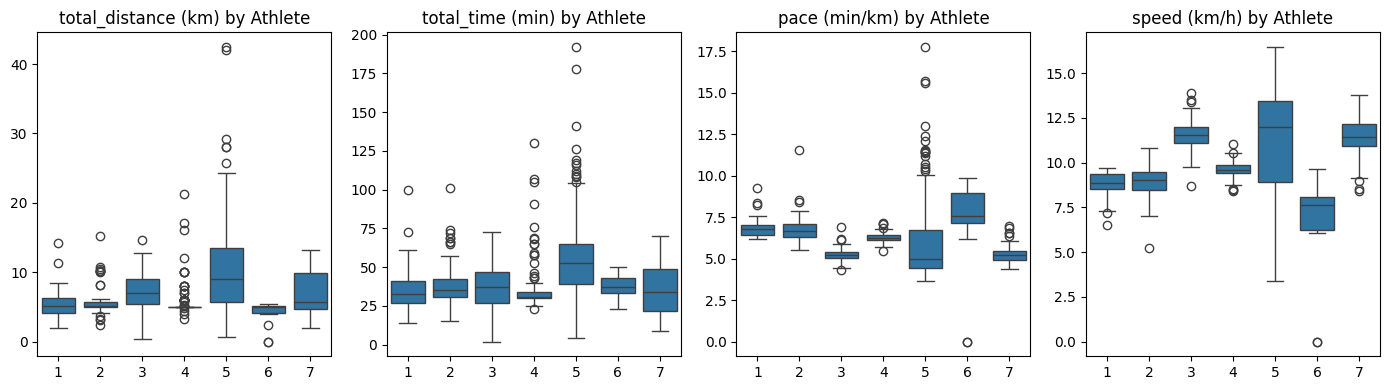

In [161]:
# Criar a figura e os eixos
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 4))

#sns.boxplot(df_athletes_activities_new, y = 'total_distance (km)', x ='athlete_id')

# Plotar boxplots para cada feature
for i, ax in enumerate(axes):
    sns.boxplot(x = df_athletes_activities_new['athlete_id'], y = df_athletes_activities_new[['total_distance (km)','total_time (min)','pace (min/km)', 'speed (km/h)']].iloc[:, i], ax=ax)
    ax.set_title(f"{df_athletes_activities_new[['total_distance (km)','total_time (min)','pace (min/km)', 'speed (km/h)']].columns[i]} by Athlete")
    ax.set_xlabel('')  # Remover o nome do eixo x
    ax.set_ylabel('')  # Remover o nome do eixo y

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [162]:
df_athletes_activities_new[df_athletes_activities_new['total_distance (km)'] == 0]

,athlete_id,activity_date,activity_type,total_distance (km),total_time (min),pace (min/km),speed (km/h)
851,6,2023-08-14,run,0.0,25.0,0.0,0.0
899,6,2023-11-27,run,0.0,39.0,0.0,0.0


In [163]:
# Contando apenas atividades com distância acima de 0
df_athletes_activities_new = df_athletes_activities_new[df_athletes_activities_new['total_distance (km)'] != 0]

##### Outliers são possíveis nesse cenário pois valores altos de distância e tempo podem ser por conta de alguma prova de rua mais longa;

In [164]:
df_athletes_activities_new.drop('activity_type', axis=1).to_csv('C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/scripts_prediction_model/final/st1_df_athletes_activities.csv', index = False)